In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

#### Набор данных Samsung Human Activity Recognition
Пытаемся кластеризовать по виду активности человека с телефоном в кармане - ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

In [8]:
# Загрузим данные
X_train = np.loadtxt("samsung_train.txt")
y_train = np.loadtxt("samsung_train_labels.txt").astype(int)

X_test = np.loadtxt("samsung_test.txt")
y_test = np.loadtxt("samsung_test_labels.txt").astype(int)
print X_train[:5, :5]

[[ 0.28858451 -0.02029417 -0.13290514 -0.9952786  -0.98311061]
 [ 0.27841883 -0.01641057 -0.12352019 -0.99824528 -0.97530022]
 [ 0.27965306 -0.01946716 -0.11346169 -0.99537956 -0.96718701]
 [ 0.27917394 -0.02620065 -0.12328257 -0.99609149 -0.9834027 ]
 [ 0.27662877 -0.01656965 -0.11536185 -0.99813862 -0.98081727]]


In [10]:
# Выведем размерности
print("X_train.shape=", X_train.shape)
print("X_test.shape=", X_test.shape)

('X_train.shape=', (7352L, 561L))
('X_test.shape=', (2947L, 561L))


In [11]:
# Объединим временно тестовую и тренировочную выборки, выведем размеры
X = np.vstack((X_train, X_test))
y = np.hstack((y_train, y_test))
print(y.shape)
print(X.shape)

(10299L,)
(10299L, 561L)


In [12]:
# Вывод количества классов в выборке
n_classes = np.unique(y).size
n_classes

6

#### Соответствие меток:
1 - ходьба
2 - подъем по лестнице
3 - спуск по лестнице
4 - сидение
5 - стояние
6 - лежание

#### Масштабируем выборку

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(X_scaled[:5, :5])

[[ 0.21053385 -0.06870264 -0.45219453 -0.88333495 -0.94543102]
 [ 0.06020848  0.03590235 -0.27522188 -0.89009781 -0.92981697]
 [ 0.07845971 -0.04642696 -0.08554806 -0.8835651  -0.91359754]
 [ 0.0713747  -0.22779376 -0.27074107 -0.88518802 -0.94601495]
 [ 0.0337379   0.03161734 -0.12137951 -0.88985467 -0.94084632]]


#### Понижаем размерность с помощью PCA, 
оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных.

In [24]:
from sklearn.decomposition import PCA
pca = PCA(0.90, random_state=17)
X_pca = pca.fit_transform(X)

# Выведем количество главных компонент, нужное чтобы объяснить 90% данных
print "количество признаков после применения PCA -", pca.n_components_

количество признаков после применения PCA - 36


То же самое для отмасштабированных данных:

In [25]:
from sklearn.decomposition import PCA
pca = PCA(0.90, random_state=17)
X_pca = pca.fit_transform(X_scaled)

# Выведем количество главных компонент, нужное чтобы объяснить 90% отмасштабированных данных
print "количество признаков после применения PCA -", pca.n_components_

количество признаков после применения PCA - 65


Выведем сколько процентов дисперсии приходится на 1-ю главную компоненту:

In [26]:
print(pca.explained_variance_ratio_)

[0.50738221 0.06239186 0.02692564 0.02452871 0.01888936 0.01631395
 0.01414533 0.01216211 0.00985248 0.00949228 0.00858304 0.0080998
 0.00765863 0.00676668 0.00630242 0.00615718 0.00595335 0.00577195
 0.00563431 0.0054083  0.00518828 0.00502742 0.00473229 0.00463818
 0.00446848 0.00439868 0.00416863 0.00400809 0.00389072 0.00381339
 0.0036687  0.00364357 0.00349225 0.00346736 0.00335539 0.00329411
 0.00323824 0.00300508 0.00294254 0.00290452 0.00275765 0.00269864
 0.00264196 0.0025803  0.00255031 0.00247776 0.00245537 0.0023829
 0.00235902 0.00232044 0.0022836  0.00219182 0.00212631 0.00209145
 0.0020348  0.00201167 0.00198111 0.00194391 0.00192509 0.00189539
 0.00186403 0.00182923 0.00180956 0.00176364 0.00174188]


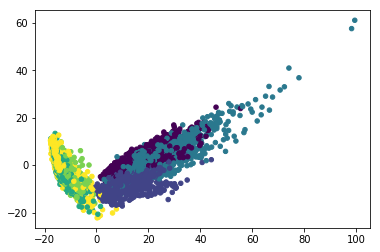

In [32]:
# X - все строки 1-го столбца, y - все строки 2-го столбца новых PCA данных
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis');

Итого, образовалось 2 опознаваемых кластера
#### Сделаем кластеризацию с помощью Kmeans на отмасштабированных данных со сниженной за счёт РСА размерностью 

In [34]:
%%time
from sklearn.cluster import KMeans, AgglomerativeClustering
kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=17)
kmeans.fit(X_pca)

Wall time: 9.81 s


Визуализируем откластеризованные данные

In [36]:
print np.unique(kmeans.labels_)

[0 1 2 3 4 5]


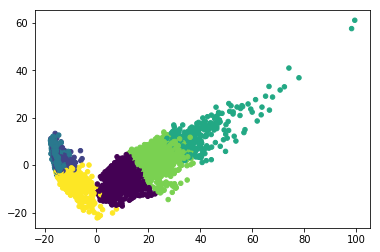

In [37]:
plt.scatter(X_pca[:, 0], X_pca[:, 1] , c=kmeans.labels_, s=20,  cmap='viridis');

Вывод соответствия между метками кластеров и исходными метками классов

In [40]:
tab = pd.crosstab(y, kmeans.labels_, margins=True)
tab.index = ['ходьба', 'подъем по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,903,0,0,78,741,0,1722
подъем по лестнице,1241,0,0,5,296,2,1544
спуск по лестнице,320,0,0,196,890,0,1406
сидение,1,1235,91,0,0,450,1777
стояние,0,1344,0,0,0,562,1906
лежание,5,52,1558,0,0,329,1944
все,2470,2631,1649,279,1927,1343,10299


Подъём наверх лучше всего отделился от остальных (берется значение из таблицы на пересечении нужной активности (слева) и самым большим значением в строке (соответствует кластеру, который образовался под эту активность)
делим это на значение в последнем столбце) -оцениваем точность, т.е долю объектов в классе, отнесенных к одному кластеру

#### Выясним с помощью метода локтя оптимальное число кластеров

 Исполняем алгоритм от 1 до 6 раз, посчитаем инерцию (сумма квадратов отклонений объектов от центра кластеров)

In [42]:
%%time
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=17)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)
print(inertia)


[5202757.681643931, 2697926.758229884, 2346425.104344863, 2207131.5104358857, 2080985.1305780779, 2003454.7982992895]
Wall time: 38.4 s


Выведем график изменения инерции в зависимости от кол-ва изначально заданных кластеров

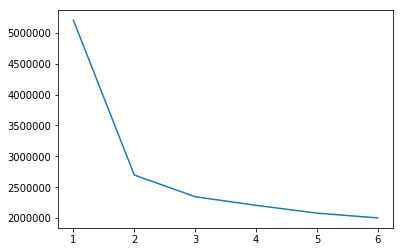

In [43]:
x = [1, 2, 3, 4, 5, 6]
y2 = inertia
plt.plot(x, y2)

Видим, что значение инерции начинает изменяться медленно со значения k=2, следовательно, разбиение на два кластера - оптимально
Это соответствует первоначальному графику, когда мы строили первые два признака X_pca - на рисунке также визуальны четко были видны 2 кластера

#### Используем метод кластеризации Agglomerative clustering

кластеризуем и обучим на масштабированных PCA данных с k=6

In [44]:
ag = AgglomerativeClustering(n_clusters=n_classes, 
                             linkage='ward').fit(X_pca)

Посчитаем ARI для Kmeans и Agglomerative clustering

In [45]:
from sklearn.metrics import adjusted_rand_score
print adjusted_rand_score(y, kmeans.labels_)
print adjusted_rand_score(y, ag.labels_)

0.41980700126
0.49362763373


Исходя из значений ARI:

KMeans справился с кластеризацией хуже, чем Agglomerative Clustering.        
В случае случайного разбиения на кластеры ARI будет близок к нулю

#### Теперь переходим от кластеризации к классификации:

#### Решаем задачу классификации с помощью LinearSVC

масштабируем X_train, X_test

In [46]:
scaler=StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [49]:
from sklearn.svm import LinearSVC
svc = LinearSVC(random_state=17)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

Обучим GridSearch на тестовой выборке, определим лучшую модель

In [59]:
%%time
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(cv=3,estimator=svc,param_grid=svc_params)
grid.fit(X_train_scaled, y_train)
best_svc = grid.best_estimator_
best_svc

Wall time: 57 s


Применим классификатор на тестовых данных

In [52]:
y_predicted = best_svc.predict(X_test_scaled)

Выведем кросс-таблицу для предсказанных и реальных тестовых значений

In [55]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем по лестнице', 'спуск по лестнице', 
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,412,1,1,0,420
сидение,0,4,0,427,60,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,412,443,589,526,2947


По горизонтали - оценивается точность, по вертикали (справа) - полнота

Посчитаем точность и полноту через метрики sklearn

In [56]:
from sklearn.metrics import completeness_score
from sklearn.metrics import accuracy_score
print "accuracy_score=", accuracy_score(y_pred=y_predicted, y_true=y_test)
print "completeness_score=", completeness_score(labels_pred=y_predicted, labels_true=y_test)

accuracy_score= 0.9619952494061758
completeness_score= 0.9153616910151656


#### Решаем задачу классификации с помощью LinearSVC + применяем PCA к признакам

In [58]:
pca = PCA(0.90, random_state=17)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
svc = LinearSVC(random_state=17)

In [60]:
%%time
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(cv=3, estimator=svc, param_grid=svc_params)
grid.fit(X_train_pca, y_train)
best_svc = grid.best_estimator_
best_svc

Wall time: 10.6 s


Процесс ускорился на 47 сек.

Применим классификатор на тестовых данных

In [61]:
y_predicted_pca = best_svc.predict(X_test_pca)

Выведем кросс-таблицу для предсказанных и реальных тестовых значений

In [62]:
tab = pd.crosstab(y_test, y_predicted_pca, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,474,16,5,0,0,1,496
подъем вверх по лестнице,49,402,20,0,0,0,471
спуск по лестнице,5,24,389,0,1,1,420
сидение,0,1,0,422,66,2,491
стояние,3,0,0,40,487,2,532
лежание,0,0,0,2,0,535,537
все,531,443,414,464,554,541,2947


Снова посчитаем точность и полноту, с учетом того что мы обучили не на простых данных, а обработанных через PCA

In [65]:
print "accuracy_score=", accuracy_score(y_pred=y_predicted_pca, y_true=y_test)
print "completeness_score=", completeness_score(labels_pred=y_predicted_pca, labels_true=y_test)

accuracy_score= 0.9192399049881235
completeness_score= 0.8335231242062794


#### Итого, в результате применения PCA к исходным масштабированным признакам:
Точность уменьшилась на 5%

Полнота уменьшилась на 8%

Время обучения снизилось в 4.7 раза - с 57 до 10 секунд